# Span情報がない平均報酬強化学習（simulatorあり）

参考：
* [Span-Agnostic Optimal Sample Complexity and Oracle Inequalities for Average-Reward RL](https://arxiv.org/abs/2502.11238)

今回はSpanが不要な平均MDPでの学習です．Simulatorを使います．

表記：
* MDP：$M \in \mathcal{M}$
* 最大作用素：$M(x)_s=\max _a x_{s a}$
* ゲイン：$\rho^\pi(s):=\lim _{T \rightarrow \infty} \frac{1}{T} \mathbb{E}_s^\pi\left[\sum_{t=0}^{T-1} R_t\right]$
* バイアス：$h^\pi(s):=\mathrm{C}-\lim _{T \rightarrow \infty} \mathbb{E}_s^\pi\left[\sum_{t=0}^{T-1}\left(R_t-\rho^\pi\left(S_t\right)\right)\right]$
* Blackwell-最適：$V_\gamma^{\pi^*} \geq V_\gamma^\pi, \forall \pi$ が任意の$\gamma \geq \bar{\gamma}$で成立するような$\bar{\gamma}$が存在．
* 遷移確率の推定：$\widehat{P}\left(s^{\prime} \mid s, a\right)=\frac{1}{n} \sum_{i=1}^n \mathbb{I}\left\{S_{s, a}^i=s^{\prime}\right\}$

## アルゴリズムのポイント

アルゴリズムに入る前に，今回のお気持ちと証明の流れを確認しましょう．
まず，次の補題がめちゃ大事です．

---

**補題6：割引率と平均報酬の変形**

weakly communicating な環境では，次が成立します．（TODO: これWeakly communicating以外でも成立するのでは？）

詳しくは[(RL_useful_lemma/RL_AverageReward_lemma.ipynb](RL_useful_lemma/RL_AverageReward_lemma.ipynb)参照．

1. $(1-\gamma)\left(\min _s V_\gamma^{\star}(s)\right) \mathbf{1} \leq \rho^{\star} \leq(1-\gamma)\left(\max _s V_\gamma^{\star}(s)\right) \mathbf{1}$
    * つまり，$\left\|\rho^{\star}-(1-\gamma) V_\gamma^{\star}\right\|_{\infty} \leq(1-\gamma)\left\|V_\gamma^{\star}\right\|_{\text {span }}$.
2. 任意の方策$\pi$について，$(1-\gamma)\left(\min _s V_\gamma^\pi(s)\right) \mathbf{1} \leq \rho^\pi \leq(1-\gamma)\left(\max _s V_\gamma^\pi(s)\right) \mathbf{1}$,
    * つまり，$\left\|\rho^\pi-(1-\gamma) V_\gamma^\pi\right\|_{\infty} \leq(1-\gamma)\left\|V_\gamma^\pi\right\|_{\mathrm{span}}$
3. 任意の方策$\pi$について，
$
\rho^\pi \geq \rho^{\star}-(1-\gamma)\left(\left\|V_\gamma^\pi-V_\gamma^{\star}\right\|_{\infty}+\left\|V_\gamma^{\star}\right\|_{\text {span }}\right)
$

---

この補題から，次のように最適な平均報酬を挟むことができます：
任意の方策$\pi$と$\gamma$について，

$$
(1-\gamma)\left(\min _s V_\gamma^{\pi}(s)\right) \mathbf{1} \leq \rho^{\pi} 
 \leq \rho^{\star} 
 \leq(1-\gamma)\left(\max _s V_\gamma^{\star}(s)\right) \mathbf{1}
$$

**注意**
* [RL_AverageReward_Basic_Gain_and_Bias.ipynb](RL_AverageReward_Basic_Gain_and_Bias.ipynb)でやりましたが，
$(1-\gamma)\left(\min _s V_\gamma^{\pi}(s)\right)$は$\gamma \to 1$で$\rho^\pi$に収束していきます．
* weakly-communicatingでは$\rho^*$は定数関数ですが，$\rho^\pi$は定数関数とは限りません．よって，$\mathbf{1}$でベクトルの要素比較を考える必要があります．

---

これを踏まえて，アルゴリズムの方針を考えましょう．
割引率の系列 $\{\gamma_1, \gamma_2, \dots\}$について，その割引最適方策を$\{\pi_1, \pi_2, \dots\}$としましょう．
上の補題より，
$$
(1-\gamma_i)\left(\min _s V_{\gamma_i}^{\pi_i}(s)\right) \mathbf{1} \leq \rho^{\pi_i} 
 \leq \rho^{\star} 
 \leq(1-\gamma_i)\left(\max _s V_{\gamma_i}^{\star}(s)\right) \mathbf{1}
$$
が成り立ちます．上のコメントから，$\gamma_i \to 1$で下界と上界の差がだんだんなくなっていくはずです．
実際，補題の３つ目の主張から
$
\rho^{\pi^\star_\gamma} \geq \rho^{\star}-(1-\gamma)\left\|V_\gamma^{\star}\right\|_{\text {span }}
$
なので，その早さは$(1-\gamma)\left\|V_\gamma^{\star}\right\|_{\text {span }}$の$\gamma \to 1$での挙動になります．
ここでさらに，[RL_useful_lemma/RL_AverageReward_lemma.ipynb](RL_useful_lemma/RL_AverageReward_lemma.ipynb)
より，$\|V_\gamma^*\|_{\text{span}} \leq 2 \|h^\star\|_{\text{span}}$なので，結局
$$
2(1-\gamma)\left\|h^{\star}\right\|_{\text {span }} \geq 
(1-\gamma)\left\|V^{\star}_\gamma\right\|_{\text {span }} \geq 
\rho^{\star}-\rho^{\pi^\star_\gamma}
$$
の早さで上界と下界の差が収束します．
すなわち，
$$
1 - \gamma_i = 1, \frac{1}{2}, \frac{1}{4}, \dots
$$
と増やしていけば，$\log \frac{\|h^\star\|_{\text{span}}}{\varepsilon}$個目の$\gamma_i$で，$\varepsilon$だけ最適ゲインに近い$\gamma$が得られるわけですね．

**コメント**：ここ，Puterman本になんか言及ないかな…

---

ちょっと確認してみましょう．（若干swimでの挙動が怪しいですが，まああってるぽい？）

In [16]:
import numpy as np
import jax.numpy as jnp
from jax.random import PRNGKey
import jax
from typing import NamedTuple, Optional

key = PRNGKey(0)

S = 10  # 状態集合のサイズ
A = 8  # 行動集合のサイズ
S_set = jnp.arange(S)  # 状態集合
A_set = jnp.arange(A)  # 行動集合

# 報酬行列を適当に作ります
key, _ = jax.random.split(key)
rew = jax.random.uniform(key=key, shape=(S, A))
assert rew.shape == (S, A)


# 遷移確率行列を適当に作ります
key, _ = jax.random.split(key)
P = jax.random.dirichlet(key=key, alpha=jnp.array([0.3] * S), shape=((S*A,)))
P = P.reshape(S, A, S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


class MDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    rew: jnp.array  # 報酬行列
    P: jnp.array  # 遷移確率行列

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)

ergodic_mdp = MDP(S_set, A_set, rew, P)


# もっと難しいMDPも作ります
# https://arxiv.org/abs/2406.01234 のriver swim環境

S = 3  # 状態集合のサイズ
A = 2  # 行動集合のサイズ．LEFTが0, RIGHTが1とします
S_set = jnp.arange(S)  # 状態集合
A_set = jnp.arange(A)  # 行動集合


# 報酬行列（論文中では確率的ですが，今回は面倒なので決定的にします）
rew = np.zeros((S, A))
rew[0, 0] = 0.05
rew[-1, 1] = 0.95
rew = jnp.array(rew)
assert rew.shape == (S, A)


# 遷移確率行列
P = np.zeros((S, A, S))
for s in range(1, S-1):
    P[s, 0, s-1] = 1  # LEFT
    P[s, 1, s-1] = 0.05  # RIGHT
    P[s, 1, s] = 0.6  # RIGHT
    P[s, 1, s+1] = 0.35  # RIGHT

# at s1
P[0, 0, 0] = 1  # LEFT
P[0, 1, 0] = 0.6  # RIGHT
P[0, 1, 1] = 0.4  # RIGHT
P[-1, 0, -2] = 1  # LEFT
P[-1, 1, -2] = 0.05  # RIGHT
P[-1, 1, -1] = 0.95  # RIGHT

P = P.reshape(S, A, S)
P = jnp.array(P)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します

swim_mdp = MDP(S_set, A_set, rew, P)

In [19]:
from functools import partial


@partial(jax.jit, static_argnames=("iters", "S", "A"))
def _compute_discounted_V(mdp: MDP, gamma: float, iters: int, S: int, A: int):
    def backup(optimal_Q):
        next_v = mdp.P @ optimal_Q.max(axis=1)
        assert next_v.shape == (S, A)
        return mdp.rew + gamma * next_v
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    optimal_Q = jax.lax.fori_loop(0, iters, body_fn, optimal_Q)

    optimal_policy = jnp.zeros_like(optimal_Q)
    optimal_policy = optimal_policy.at[jnp.arange(S), optimal_Q.argmax(axis=1)].set(1)
    return optimal_Q.max(axis=1), optimal_policy

compute_discounted_V = lambda gamma, mdp: _compute_discounted_V(mdp, gamma, int(1 / (1-gamma) * 10), mdp.S, mdp.A)


@jax.jit
def compute_optimal_gain(mdp: MDP, tol: float = 1e-6) -> jnp.array:
    ref_state = 0 
    def condition_fun(nV_V):
        nV, V = nV_V
        span_diff = jnp.abs(nV - V).max()
        return span_diff > tol

    def body_fun(nV_V):
        V, _ = nV_V
        gain = V[ref_state]
        next_v = mdp.P @ V
        nV = (mdp.rew + next_v).max(axis=1) - gain
        return (nV, V)

    init_V = jnp.zeros((mdp.S))
    nV_V = body_fun((init_V, init_V))
    V, _ = jax.lax.while_loop(condition_fun, body_fun, nV_V)
    return V[ref_state], V.max() - V.min()  # gain, span


@jax.jit
def compute_expected_gain(mdp: MDP, policy: jnp.ndarray, tol: float = 1e-6) -> jnp.array:
    ref_state = 0 
    def condition_fun(nV_V):
        nV, V = nV_V
        span_diff = jnp.abs(nV - V).max()
        return span_diff > tol

    def body_fun(nV_V):
        V, _ = nV_V
        gain = V[ref_state]
        next_v = mdp.P @ V
        nV = jnp.sum((mdp.rew + next_v) * policy, axis=1) - gain
        return (nV, V)

    init_V = jnp.zeros((mdp.S))
    nV_V = body_fun((init_V, init_V))
    V, _ = jax.lax.while_loop(condition_fun, body_fun, nV_V)
    return V[ref_state], V.max() - V.min()  # gain, span


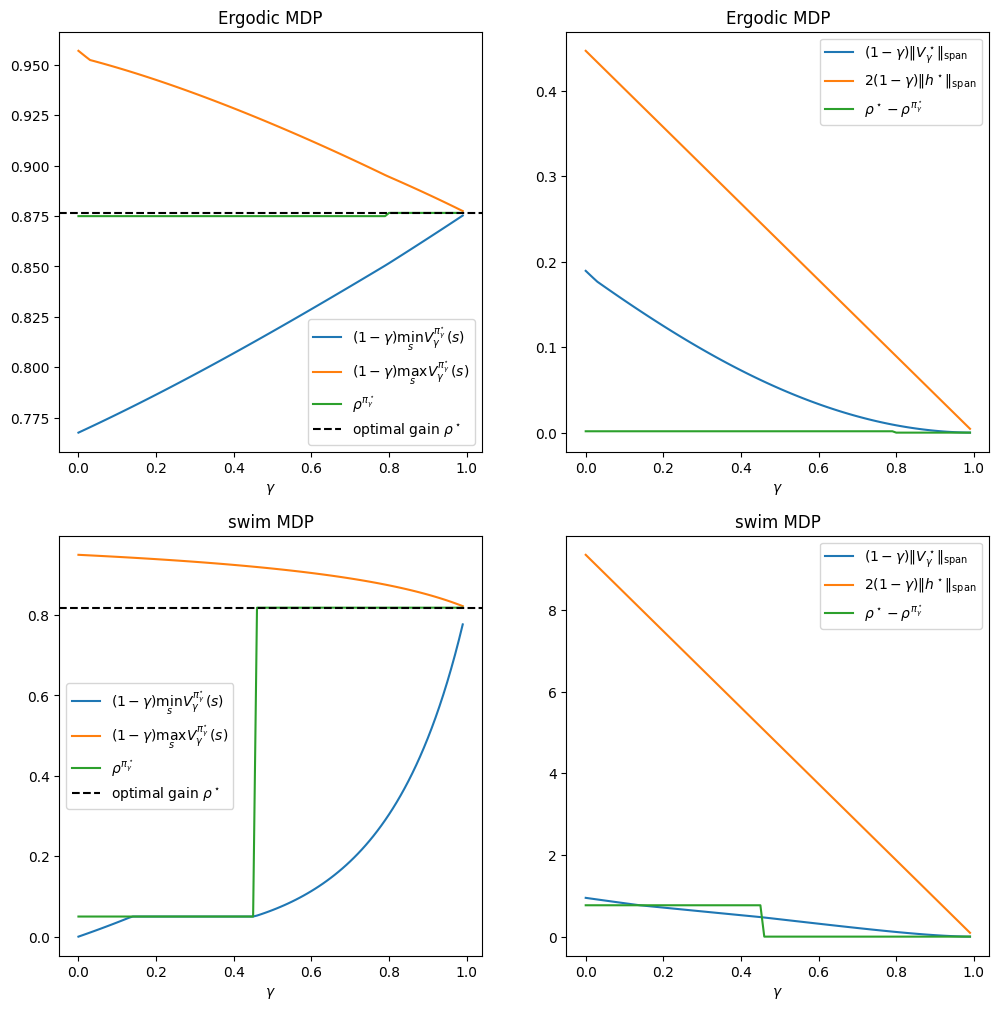

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
gammas = jnp.linspace(0, 0.99, 100)

# ergodic mdp
optimal_gain, optimal_span = compute_optimal_gain(ergodic_mdp)
lowers = []
uppers = []
gains = []
discounted_spans = []
for gamma in gammas:
    V, pol = compute_discounted_V(gamma, ergodic_mdp)
    gain, _ = compute_expected_gain(ergodic_mdp, pol)
    gains.append(gain)
    lower_bound = (1 - gamma) * V.min()
    upper_bound = (1 - gamma) * V.max()
    V_span = upper_bound - lower_bound
    lowers.append(lower_bound)
    uppers.append(upper_bound)
    discounted_spans.append((1 - gamma) * V_span)

lowers = jnp.array(lowers)
uppers = jnp.array(uppers)
gains = jnp.array(gains)
discounted_spans = jnp.array(discounted_spans)

plt.subplot(2, 2, 1)
plt.title("Ergodic MDP")
plt.plot(gammas, lowers, label=r"$(1-\gamma) \min_s V^{\pi_\gamma^\star}_{\gamma}(s)$")
plt.plot(gammas, uppers, label=r"$(1-\gamma) \max_s V^{\pi_\gamma^\star}_{\gamma}(s)$")
plt.plot(gammas, gains, label=r"$\rho^{\pi_\gamma^\star}$")
plt.axhline(optimal_gain, color="black", linestyle="--", label=r"optimal gain $\rho^\star$")
plt.xlabel(r"$\gamma$")
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Ergodic MDP")
plt.plot(gammas, discounted_spans, label=r"$(1-\gamma) \|V^\star_{\gamma}\|_{\text{span}}$")
plt.plot(gammas, 2 * (1-gammas) * optimal_span, label=r"$2 (1-\gamma) \|h^\star\|_{\text{span}}$")
plt.plot(gammas, optimal_gain - gains, label=r"$\rho^\star - \rho^{\pi_\gamma^\star}$")
plt.xlabel(r"$\gamma$")
plt.legend()

# swim mdp
optimal_gain, optimal_span = compute_optimal_gain(swim_mdp)
lowers = []
uppers = []
gains = []
discounted_spans = []
for gamma in gammas:
    V, pol = compute_discounted_V(gamma, swim_mdp)
    gain, _ = compute_expected_gain(swim_mdp, pol)
    gains.append(gain)
    lower_bound = (1 - gamma) * V.min()
    upper_bound = (1 - gamma) * V.max()
    V_span = upper_bound - lower_bound
    lowers.append(lower_bound)
    uppers.append(upper_bound)
    discounted_spans.append((1 - gamma) * V_span)

lowers = jnp.array(lowers)
uppers = jnp.array(uppers)
gains = jnp.array(gains)
discounted_spans = jnp.array(discounted_spans)

plt.subplot(2, 2, 3)
plt.title("swim MDP")
plt.plot(gammas, lowers, label=r"$(1-\gamma) \min_s V^{\pi_\gamma^\star}_{\gamma}(s)$")
plt.plot(gammas, uppers, label=r"$(1-\gamma) \max_s V^{\pi_\gamma^\star}_{\gamma}(s)$")
plt.plot(gammas, gains, label=r"$\rho^{\pi_\gamma^\star}$")
plt.axhline(optimal_gain, color="black", linestyle="--", label=r"optimal gain $\rho^\star$")
plt.xlabel(r"$\gamma$")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("swim MDP")
plt.plot(gammas, discounted_spans, label=r"$(1-\gamma) \|V^\star_{\gamma}\|_{\text{span}}$")
plt.plot(gammas, 2 * (1-gammas) * optimal_span, label=r"$2 (1-\gamma) \|h^\star\|_{\text{span}}$")
plt.plot(gammas, optimal_gain - gains, label=r"$\rho^\star - \rho^{\pi_\gamma^\star}$")
plt.xlabel(r"$\gamma$")
plt.legend()


## サンプル近似しよう

上で求めたバウンドは真の$P$がわからないと使えません．そこで，$n$個のサンプルで近似した$\widehat{P}$を使ったバウンドに直しましょう（面倒なので，Exactな割引最適価値は計算できることにします）．
上のバウンドを復習すると，
$$
(1-\gamma_i)\left(\min _s V_{\gamma_i}^{\pi_i}(s)\right) \mathbf{1} \leq \rho^{\pi_i} 
 \leq \rho^{\star} 
 \leq(1-\gamma_i)\left(\max _s V_{\gamma_i}^{\star}(s)\right) \mathbf{1}
$$
でした．まず上界については，
$$
\begin{aligned}
\rho^{\star} 
&\leq(1-\gamma_i)\left(\max _s V_{\gamma_i}^{\star}(s)\right) \mathbf{1}\\
&\leq(1-\gamma_i)\left(\max _s \widehat{V}_{\gamma_i}^{\star}(s)\right) \mathbf{1}
+ (1-\gamma_i)\left\|\widehat{V}_{\gamma_i}^{\star} - V_{\gamma_i}^{\star}\right\|_\infty \mathbf{1}
\end{aligned}
$$
ですね．
$\pi_i$を$\widehat{P}$での$\gamma_i$-割引最適方策とすると，
下界は
$$
\begin{aligned}
\rho^{\pi_i} 
&\geq (1-\gamma_i)\left(\min _s V_{\gamma_i}^{\pi_i}(s)\right) \mathbf{1} \\
&\geq (1-\gamma_i)\left(\min _s \widehat{V}_{\gamma_i}^{\star}(s)\right) \mathbf{1} 
- (1-\gamma_i)\left\|\widehat{V}_{\gamma_i}^{\star} - V_{\gamma_i}^{\star}\right\|_\infty \mathbf{1}
\end{aligned}
$$
なので，結局
$$
\rho^\star - \rho^{\pi_i} \leq 
(1-\gamma_i)\left\|\widehat{V}_{\gamma_i}^{\star} \right\|_\text{span}\mathbf{1} + 
2(1-\gamma_i)\left\|\widehat{V}_{\gamma_i}^{\star} - V_{\gamma_i}^{\star}\right\|_\infty \mathbf{1}
$$
が得られます．

* ２項目：詳細は省略しますが，Bernsteinなどを使えば２項目は結局
$\lesssim \sqrt{\frac{\left\|h^\star\right\|_{\text {span }}}{n}}$
でバウンドされます．
* １項目：TODO: 続き書く．多分三角不等式で上から$(1-\gamma_i) \left\|h^\star \right\|_\text{span}$
でバウンドできるはず．


$(1-\gamma_i)^{-1} \approx \sqrt{n \left\|h^\star \right\|_\text{span}}$なる$\gamma_i$を設定すれば，１項目と２項目のオーダーが同じになります．しかし，$\left\|h^\star \right\|_\text{span}$は不明なので，この設定の仕方はできません．

そこで，$\sqrt{n} \leq (1-\gamma_i)^{-1} \leq n$になるように設定しましょう．このとき，十分大きな$\left\|h^\star \right\|_\text{span} \leq \sqrt{n}$なる$n$であれば，１項目と２項目のオーダーが同じになります．
アルゴリズムとしては
1. 割引率は$n$によって決める
2. $n$は指数的にデカくしていく

をすれば良く，上界と下界の差を見てアルゴリズムを停止すれば良いです．そして，そのサンプル効率は結局$\sqrt{\frac{\left\|h^\star\right\|_{\text {span }}}{n}}$くらいになるので，Minimax 最適になります．

### （↓昔のメモ）
$$
\gamma_i^{\star}=\inf \left\{\gamma \in \mathcal{H}_i: \frac{1}{1-\gamma} \geq \sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)}\right\}
$$
を定義します．
$\mathcal{H}_i$は
$$
\mathcal{H}_i:=\left\{\gamma: \text { there exists an integer } k \text { such that } \sqrt{n_i} \leq \frac{1}{1-\gamma}=2^k \leq n_i\right\}
$$
で定義されていたことを思い出しましょう．もし $\left\|h^{\star}\right\|_{\text {span }} \approx n_i$なら，$\mathcal{H}_i$の最大値が$n_i$なので，これは$\gamma_i^\star$が該当なしになります．
該当なしの場合は$\gamma_i^\star$としましょう．
このとき，次が成立します．

任意の$i \geq 1$について，$\left\|h^{\star}\right\|_{\text {span }}+1 \leq n_i$ を考えましょう．このとき，
$\gamma^*_i$は有限であり，
$$
\sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)} \leq \frac{1}{1-\gamma_i^{\star}} \leq 2 \sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)}
$$
が成立します．
証明は簡単なので省略．

これを使うと，次のように上界と下界の差がバウンドできます．

---

**補題 12** $\left\|h^{\star}\right\|_{\text {span }}+1 \leq n_i$の$i$ を考えましょう．このとき，
$$
\widehat{U}_i\left(\gamma_i^{\star}\right)-\widehat{L}_i\left(\gamma_i^{\star}\right) \lesssim \sqrt{\frac{\left\|h^{\star}\right\|_{\text {span }}+1}{n_i}}
$$

が成立します．

**証明**
上界と下界の定義から，任意の$\gamma$と$i$について，

$$
\begin{aligned}
\widehat{U}_i(\gamma)-\widehat{L}_i(\gamma)
\lesssim & (1-\gamma)\left(\max _s \widehat{V}^\star_{\gamma, i}(s)-\min _s \widehat{V}^\star_{\gamma, i}(s)\right)+\frac{1}{(1-\gamma) n_i} 
+ \sqrt{\frac{\left\|\widehat{V}^\star_{\gamma, i}\right\|_{\text {span }}+1}{n_i}} \\
\lesssim & (1-\gamma)\left\|\widehat{V}^\star_{\gamma, i}\right\|_{\text {span }}+\frac{1}{(1-\gamma) n_i} 
+ \sqrt{\frac{\left\|\widehat{V}^\star_{\gamma, i}\right\|_{\text {span }}+1}{n_i}} 
\end{aligned}
$$

さて，１項目が邪魔ですね．まず，上でやった$\|\widehat{V}^\star_{\gamma, i} - V^\star_{\gamma}\|$のバウンドを使って変形すれば，上から$\left\|V^\star_{\gamma}\right\|_{\text {span }}$でバウンドできます．
ここで，さらに$\left\|V^\star_{\gamma}\right\|_{\text {span }}\leq 2\left\|h^\star\right\|_{\text{span}}$を使えば，だいたい１項目が$(1-\gamma)\|h^\star\|_{\mathrm{span}}$でバウンドされます．

最後に，上で導出した
$$
\sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)} \leq \frac{1}{1-\gamma_i^{\star}} \leq 2 \sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)}
$$
を使います．ひっくり返すと，
$$
(1-\gamma_i^\star) \|h^\star\|_{\mathrm{span}} \leq \sqrt{\frac{\|h^\star\|_{\mathrm{span}}}{n_i}}
$$
で１項目をバウンドできます．

つまり，$n_i$がだいたい$\frac{\left|h^{\star}\right|_{\text {apan }}+1}{\varepsilon^2}$のオーダーであれば，上界と下界の差を$\varepsilon$で抑えて，最適ゲインが獲得されます．



### 上界と下界をさらに挟む

---

**補題 10**

任意の$i$と$\gamma \in \mathcal{H}_i$について，

$$
\widehat{L}_i(\gamma) \mathbf{1} \leq \rho^{\widehat{\pi}^\star_{\gamma, i}} \leq \rho^{\star} \leq \widehat{U}_i(\gamma) \mathbf{1}
$$

が成立します．

**証明**
平均と割引の変形から，
$$
(1-\gamma)\left(\min _s V_\gamma^{\widehat{\pi}^\star_{\gamma, i}}(s)\right) \mathbf{1} \leq \rho^{\widehat{\pi}^\star_{\gamma, i}} 
 \leq \rho^{\star} 
 \leq(1-\gamma)\left(\max _s V_\gamma^{\star}(s)\right) \mathbf{1}
$$

ここで，
$$
\begin{aligned}
(1-\gamma)\left(\min _s V_\gamma^{\widehat{\pi}^\star_{\gamma, i}}(s)\right) \mathbf{1} & \geq(1-\gamma)\left(\min _s \widehat{V}_{\gamma, i}^{\star}(s)\right) \mathbf{1}-(1-\gamma)\left\|\widehat{V}_{\gamma, i}^{\widehat{\pi}^\star_{\gamma, i}}-V_\gamma^{\widehat{\pi}^\star_{\gamma, i}}\right\|_{\infty} \mathbf{1} \\
& \gtrsim(1-\gamma)\left(\min _s \widehat{V}_{\gamma, i}^{\star}(s)\right) \mathbf{1}-\sqrt{\frac{\left\|\widehat{V}_{\gamma, i}^{\star}\right\|_{\text {span }}+1}{n_i}} \mathbf{1} .
\end{aligned}
$$

上界も似たような変形で出ます．

**これはつまり，上界と下界が十分近ければ，求めた$\gamma, i$による方策がゲイン最適であることを示してます．**
後はアルゴリズムが停止することが示せれば終わりです．


## $\varepsilon$最適方策を出すアルゴリズム

**アルゴリズムのポイント** 
基本的には平均報酬を割引MDPで近似して解くアプローチです．ここで，割引率の近似を工夫するのがポイントです．
複数の割引率を選択して，それぞれの$\gamma$で最適方策$\widetilde{\pi}_\gamma$を計算します．

---

**割引率の集合** アルゴリズム中で適切な割引率を選択するために，次の割引率の範囲を構築します：
$$
\mathcal{H}_i:=\left\{\gamma: \text { there exists an integer } k \text { such that } \sqrt{n_i} \leq \frac{1}{1-\gamma}=2^k \leq n_i\right\}
$$
例えば$n_i=10$なら，
$$
\sqrt{10} \leq 4, 5, 6, 7, 8, 9, 10 \leq 10
$$
であり，$\mathcal{H}=\{3/4, 7/8\}$です．

ここで，各イテレーションで$n_i=2^i$でサンプル数を増やしていきます．

---

**割引率の上界と下界**

そして，それぞれの$\gamma \in \mathcal{H}_i$について，
$$
\begin{aligned}
& \widehat{U}_i(\gamma)\approx (1-\gamma) \max _s \widehat{V}^\star_{\gamma, i}(s)+\frac{1}{(1-\gamma) n_i}+ \underbrace{\sqrt{\frac{\left\|\widehat{V}^\star_{\gamma, i}\right\|_{\text {span }}+1}{n_i}}}_{分散の項} \\
& \widehat{L}_i(\gamma)\approx (1-\gamma) \min _s \widehat{V}^\star_{\gamma, i}(s)- \underbrace{\sqrt{\frac{\left\|\widehat{V}^\star_{\gamma, i}\right\|_{\text {span }}+1}{n_i}}}_{分散の項}
\end{aligned}
$$
とします．
ここで，$\widehat{V}^\star_{\gamma, i}$は$i$イテレーション目での近似遷移の割引最適価値です．

---

**停止条件**

最後に$\widehat{\gamma}_i:=\operatorname{argmin}_{\gamma \in \mathcal{H}_i} \widehat{U}_i(\gamma)-\widehat{L}_i(\gamma)$として，もし$\widehat{U}_i\left(\widehat{\gamma}_i\right)-\widehat{L}_i\left(\widehat{\gamma}_i\right) \leq \varepsilon$ならばアルゴリズムを終了します．

---

**直感**

直感的には，これは[sample variance penalization (SVP)](https://arxiv.org/abs/0907.3740)と呼ばれる手法の応用です．
SVPの詳細は省略しますが，単にBernsteinの上界を小さくするだけですね．
このアルゴリズムでは，SVPに基づいて，
$$
\max _{\pi, \gamma}(1-\gamma) \min _s \widehat{V}_\gamma^\pi(s)-\sqrt{\frac{\left\|\widehat{V}_\gamma^\pi\right\|_{\mathrm{span}}+1}{n}}
$$
を解くことを目指しています．これは最適化がちょっとむずかしいので，変わりに
$$
\max _\gamma(1-\gamma) \min _s \widehat{V}_\gamma^{\star}(s)-\sqrt{\frac{\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }}+1}{n}}
$$
を解いています．

---

このとき，$\widehat{\pi}^\star_{\widehat{\gamma}_i, i}$は$\varepsilon$-ゲイン最適になります．
ここで，$\widehat{\pi}^\star_{\gamma, i}$は$i$イテレーション目での近似遷移の割引最適方策です．

<!-- \widehat{V}_\gamma^{\tilde{\pi}_\gamma} \geq \widehat{V}_\gamma^{\star}-\frac{1}{n} 1 \text { and } -->

### サンプル効率の解析


#### 割引価値関数の信頼区間

**補題7**
<!-- 以下，簡単のために$\iota$を対数項として省略します． -->
確率$1-\delta$以上で，任意の$i \geq 1$と$\gamma \in \mathcal{H}_i$で次の２つが成立します：

1. **方策が真の最適方策**：$\left\|\widehat{V}_{\gamma, i}^{\pi_\gamma^*} - V_\gamma^{\pi_\gamma^*}\right\|_{\infty} \lesssim \frac{1}{1-\gamma} \sqrt{\frac{\left\|V_\gamma^{\pi_\gamma^*}\right\|_{\text {span }}+1}{n_i}}$
2. **方策が更新中の最適方策**：$\left\|\widehat{V}_{\gamma, i}^{\widehat{\pi}^\star_{\gamma, i}}-V_\gamma^{\widehat{\pi}^\star_{\gamma, i}}\right\|_{\infty} \lesssim \frac{1}{1-\gamma} \sqrt{\frac{\left\|\widehat{V}_{\gamma, i}^{\widehat{\pi}^\star_{\gamma, i}}\right\|_{\text {span }}+1}{n_i}}$

**証明** これは[The Plug-in Approach for Average-Reward and Discounted MDPs: Optimal Sample Complexity Analysis](https://arxiv.org/abs/2410.07616)のTheorem 9で証明されてる結果です（元論文の証明がしんどいので読みづらい…）．
簡単に証明しましょう．

**ステップ1** 固定された$\gamma$と$V$について考えましょう．Bernsteinを使うと，
$$
\left|\left(\widehat{P}_{s, \pi_\gamma^*(s)}-P_{s, \pi_\gamma^*(s)}\right)V\right| \lesssim \sqrt{\frac{\mathbb{V}_{P_{s, \pi^\star_\gamma(s)}}\left[V\right]}{n}}+\frac{\left\|V\right\|_{\infty}}{n}\;. 
$$
が言えます．
ここで，$V$が$\gamma$とイテレーション数に依存して選択されるとすると，$\mathcal{H}_i$の中には対数個の割引率しか出てこないので，Union Boundをとっても大丈夫そう．

**ステップ2** ちょいめんどい…．結局$\gamma$が対数回しか出てこないので，Bernstein + Union bound with Peeling techniqueをやっている気がする．
詳細はTODO．



---

**補題８（簡易版）**

上が成立しているとき，次が言えます（論文だとLemma 8ですが，論文より下のほうが簡単だと思う）：

２つのMDP $(P, r),(\hat{P}, r)$について，

1. $V^\star_\gamma \geq V^{\widehat{\pi}^\star_\gamma}_\gamma \geq \widehat{V}^{\widehat{\pi}^\star_\gamma}_\gamma - \left\|V^{\widehat{\pi}^\star_\gamma}_\gamma - \widehat{V}^{\widehat{\pi}^\star_\gamma}_\gamma\right\|_\infty$
なので
$\left\|V^{\widehat{\pi}^\star_\gamma}_\gamma - \widehat{V}^{\widehat{\pi}^\star_\gamma}_\gamma\right\|_\infty \geq \widehat{V}^\star_\gamma - V^\star_\gamma$
2. $\widehat{V}^\star_\gamma \geq \widehat{V}^{\pi^\star_\gamma}_\gamma \geq V^{\pi^\star_\gamma}_\gamma - \left\|V^{\pi^\star_\gamma}_\gamma - \widehat{V}^{\pi^\star_\gamma}_\gamma\right\|_\infty$
なので
$\left\|V^{\pi^\star_\gamma}_\gamma - \widehat{V}^{\pi^\star_\gamma}_\gamma\right\|_\infty \geq V^{\star}_\gamma - \widehat{V}^\star_\gamma$

まとめると，
$$
\left\|V^{\star}_\gamma - \widehat{V}^\star_\gamma\right\|_\infty \leq 
\left\|V^{\pi^\star_\gamma}_\gamma - \widehat{V}^{\pi^\star_\gamma}_\gamma\right\|_\infty
+ \left\|V^{\widehat{\pi}^\star_\gamma}_\gamma - \widehat{V}^{\widehat{\pi}^\star_\gamma}_\gamma\right\|_\infty 
$$

が成り立ちます．
さて，直前の補題を思い出すと，


* **方策が更新中の最適方策**：$\left\|\widehat{V}_{\gamma, i}^{\widehat{\pi}^\star_{\gamma, i}}-V_\gamma^{\widehat{\pi}^\star_{\gamma, i}}\right\|_{\infty} \lesssim \frac{1}{1-\gamma} \sqrt{\frac{\left\|\widehat{V}_{\gamma, i}^{\widehat{\pi}^\star_{\gamma, i}}\right\|_{\text {span }}+1}{n_i}}$
* **方策が真の最適方策**：$\left\|\widehat{V}_{\gamma, i}^{\pi_\gamma^*} - V_\gamma^{\pi_\gamma^*}\right\|_{\infty} \lesssim \frac{1}{1-\gamma} \sqrt{\frac{\left\|V_\gamma^{\pi_\gamma^*}\right\|_{\text {span }}+1}{n_i}}$

でした．
よって，アルゴリズム中では
$$
\begin{aligned}
&\left\|V^\star_\gamma - \widehat{V}_{\gamma, i}^{\star}\right\|_{\infty} \lesssim 
\frac{1}{1-\gamma} \sqrt{\frac{\left\|\widehat{V}_{\gamma, i}^{\star}\right\|_{\text {span }}+1}{n_i}}
+ 
\frac{1}{1-\gamma} \sqrt{\frac{\left\|V_\gamma^{\star}\right\|_{\text {span }}+1}{n_i}}
\end{aligned}
$$

が成立します．

---

**補題８（続き）**

上の不等式は２つのスパンの和が出てくる点で，ちょっと使いづらいです．
**以下をすることで上界に出てくるスパンを一種類にします**．
<!-- ここで，最後の項をさらに上からバウンドしましょう（**以下をすることで上界に出てくるスパンを一種類にします**）． -->
まず，
$$
\left\|\widehat{V}_{\gamma, i}^{\star}\right\|_{\text {span }}
\leq 
\left\|V_{\gamma}^{\star}\right\|_{\text {span }}
+ 
\left\|\widehat{V}_{\gamma, i}^{\star} - V_{\gamma}^{\star}\right\|_{\text {span }}
\leq 
\left\|V_{\gamma}^{\star}\right\|_{\text {span }}
+ 
2\left\|\widehat{V}_{\gamma, i}^{\star} - V_{\gamma}^{\star}\right\|_\infty
$$
なので，
$$
\begin{aligned}
&\left\|V^\star_\gamma - \widehat{V}_{\gamma, i}^{\star}\right\|_{\infty} \lesssim 
\frac{2}{1-\gamma} \sqrt{\frac{\left\|\widehat{V}_{\gamma, i}^{\star} - V_{\gamma}^{\star}\right\|_\infty}{n_i}}
+ 
\frac{2}{1-\gamma} \sqrt{\frac{\left\|V_\gamma^{\star}\right\|_{\text {span }}+1}{n_i}}
\end{aligned}
$$

これは二次方程式であり，解を求めれば，
$$
\begin{aligned}
&\left\|V^\star_\gamma - \widehat{V}_{\gamma, i}^{\star}\right\|_{\infty} \lesssim 
\frac{1}{(1-\gamma)^2 n_i}+\frac{1}{1-\gamma} \sqrt{\frac{\left\|V_\gamma^{\star}\right\|_{\text {span }} +1}{m}}
\end{aligned}
$$

が明らかに成立してます．同様にして，$\widehat{V}^\star_{\gamma, i}$だけを残すように変形すれば，次の不等式が成立します：
$$
\begin{aligned}
&\left\|V^\star_\gamma - \widehat{V}_{\gamma, i}^{\star}\right\|_{\infty} \lesssim 
\frac{1}{(1-\gamma)^2 n_i}+\frac{1}{1-\gamma} \sqrt{\frac{\min \left\{\left\|V_\gamma^{\star}\right\|_{\text {span }}, \left\|\bar{V}_\gamma^{\star}\right\|_{\text {span }} \right\}+1}{n_i}}
\end{aligned}
$$


### 上界と下界の差

---

**補題 10**

任意の$i$と$\gamma \in \mathcal{H}_i$について，

$$
\widehat{L}_i(\gamma) \mathbf{1} \leq \rho^{\widehat{\pi}^\star_{\gamma, i}} \leq \rho^{\star} \leq \widehat{U}_i(\gamma) \mathbf{1}
$$

が成立します．

**証明**
平均と割引の変形から，
$$
(1-\gamma)\left(\min _s V_\gamma^{\widehat{\pi}^\star_{\gamma, i}}(s)\right) \mathbf{1} \leq \rho^{\widehat{\pi}^\star_{\gamma, i}} 
 \leq \rho^{\star} 
 \leq(1-\gamma)\left(\max _s V_\gamma^{\star}(s)\right) \mathbf{1}
$$

ここで，
$$
\begin{aligned}
(1-\gamma)\left(\min _s V_\gamma^{\widehat{\pi}^\star_{\gamma, i}}(s)\right) \mathbf{1} & \geq(1-\gamma)\left(\min _s \widehat{V}_{\gamma, i}^{\star}(s)\right) \mathbf{1}-(1-\gamma)\left\|\widehat{V}_{\gamma, i}^{\widehat{\pi}^\star_{\gamma, i}}-V_\gamma^{\widehat{\pi}^\star_{\gamma, i}}\right\|_{\infty} \mathbf{1} \\
& \gtrsim(1-\gamma)\left(\min _s \widehat{V}_{\gamma, i}^{\star}(s)\right) \mathbf{1}-\sqrt{\frac{\left\|\widehat{V}_{\gamma, i}^{\star}\right\|_{\text {span }}+1}{n_i}} \mathbf{1} .
\end{aligned}
$$

上界も似たような変形で出ます．

**これはつまり，上界と下界が十分近ければ，求めた$\gamma, i$による方策がゲイン最適であることを示してます．**
後はアルゴリズムが停止することが示せれば終わりです．


#### アルゴリズムの停止性

$$
\gamma_i^{\star}=\inf \left\{\gamma \in \mathcal{H}_i: \frac{1}{1-\gamma} \geq \sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)}\right\}
$$
を定義します．
$\mathcal{H}_i$は
$$
\mathcal{H}_i:=\left\{\gamma: \text { there exists an integer } k \text { such that } \sqrt{n_i} \leq \frac{1}{1-\gamma}=2^k \leq n_i\right\}
$$
で定義されていたことを思い出しましょう．もし $\left\|h^{\star}\right\|_{\text {span }} \approx n_i$なら，$\mathcal{H}_i$の最大値が$n_i$なので，これは$\gamma_i^\star$が該当なしになります．
該当なしの場合は$\gamma_i^\star$としましょう．
このとき，次が成立します．

任意の$i \geq 1$について，$\left\|h^{\star}\right\|_{\text {span }}+1 \leq n_i$ を考えましょう．このとき，
$\gamma^*_i$は有限であり，
$$
\sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)} \leq \frac{1}{1-\gamma_i^{\star}} \leq 2 \sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)}
$$
が成立します．
証明は簡単なので省略．

これを使うと，次のように上界と下界の差がバウンドできます．

---

**補題 12** $\left\|h^{\star}\right\|_{\text {span }}+1 \leq n_i$の$i$ を考えましょう．このとき，
$$
\widehat{U}_i\left(\gamma_i^{\star}\right)-\widehat{L}_i\left(\gamma_i^{\star}\right) \lesssim \sqrt{\frac{\left\|h^{\star}\right\|_{\text {span }}+1}{n_i}}
$$

が成立します．

**証明**
上界と下界の定義から，任意の$\gamma$と$i$について，

$$
\begin{aligned}
\widehat{U}_i(\gamma)-\widehat{L}_i(\gamma)
\lesssim & (1-\gamma)\left(\max _s \widehat{V}^\star_{\gamma, i}(s)-\min _s \widehat{V}^\star_{\gamma, i}(s)\right)+\frac{1}{(1-\gamma) n_i} 
+ \sqrt{\frac{\left\|\widehat{V}^\star_{\gamma, i}\right\|_{\text {span }}+1}{n_i}} \\
\lesssim & (1-\gamma)\left\|\widehat{V}^\star_{\gamma, i}\right\|_{\text {span }}+\frac{1}{(1-\gamma) n_i} 
+ \sqrt{\frac{\left\|\widehat{V}^\star_{\gamma, i}\right\|_{\text {span }}+1}{n_i}} 
\end{aligned}
$$

さて，１項目が邪魔ですね．まず，上でやった$\|\widehat{V}^\star_{\gamma, i} - V^\star_{\gamma}\|$のバウンドを使って変形すれば，上から$\left\|V^\star_{\gamma}\right\|_{\text {span }}$でバウンドできます．
ここで，さらに$\left\|V^\star_{\gamma}\right\|_{\text {span }}\leq 2\left\|h^\star\right\|_{\text{span}}$を使えば，だいたい１項目が$(1-\gamma)\|h^\star\|_{\mathrm{span}}$でバウンドされます．

最後に，上で導出した
$$
\sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)} \leq \frac{1}{1-\gamma_i^{\star}} \leq 2 \sqrt{n_i\left(\left\|h^{\star}\right\|_{\text {span }}+1\right)}
$$
を使います．ひっくり返すと，
$$
(1-\gamma_i^\star) \|h^\star\|_{\mathrm{span}} \leq \sqrt{\frac{\|h^\star\|_{\mathrm{span}}}{n_i}}
$$
で１項目をバウンドできます．

つまり，$n_i$がだいたい$\frac{\left|h^{\star}\right|_{\text {apan }}+1}{\varepsilon^2}$のオーダーであれば，上界と下界の差を$\varepsilon$で抑えて，最適ゲインが獲得されます．

## （deprecated）$n$が固定のとき

まず，すべての状態行動について，$n$個ずつサンプルする状況を考えましょう．

**アルゴリズムのポイント** 
基本的には平均報酬を割引MDPで近似して解くアプローチです．ここで，割引率の近似を工夫するのがポイントです．
複数の割引率を選択して，それぞれの$\gamma$で最適方策$\widetilde{\pi}_\gamma$を計算します．

そのために，次の割引率の範囲を構築しましょう：
$$
\mathcal{H}:=\left\{\gamma: \text { there exists an integer } k \text { such that } \sqrt{n} \leq \frac{1}{1-\gamma}=2^k \leq n\right\}
$$
例えば$n=10$なら，
$$
\sqrt{10} \leq 4, 5, 6, 7, 8, 9, 10 \leq 10
$$
であり，$\mathcal{H}=\{3/4, 7/8\}$です．

そして，次の関数を評価します：
$$
\widehat{L}(\gamma):=(1-\gamma) \min _s \tilde{V}_\gamma(s)-2 \frac{1-\gamma}{n}-\underbrace{\alpha(\delta, n) \sqrt{\frac{\left\|\tilde{V}_\gamma\right\|_{\text {span }}+\frac{3}{n}+1}{n}}}_{\approx 分散の項}
$$

最後に
$$
\text { policy } \widehat{\pi}:=\tilde{\pi}_{\hat{\gamma}} \text {, gain lower bound } \hat{\rho}:=\max \{\widehat{L}(\widehat{\gamma}), 0\} 1
$$
where
$$
\widehat{\gamma}=\operatorname{argmax}_{\gamma \in \mathcal{H}} \widehat{L}(\gamma)
$$

を計算して終わりです．

**直感**

直感的には，これは[sample variance penalization (SVP)](https://arxiv.org/abs/0907.3740)と呼ばれる手法の応用です．
SVPの詳細は省略しますが，単にBernsteinの上界を小さくするだけですね．
このアルゴリズムでは，SVPに基づいて，
$$
\max _{\pi, \gamma}(1-\gamma) \min _s \widehat{V}_\gamma^\pi(s)-\sqrt{\frac{\left\|\widehat{V}_\gamma^\pi\right\|_{\mathrm{span}}+1}{n}}
$$
を解くことを目指しています．これは最適化がちょっとむずかしいので，変わりに
$$
\max _\gamma(1-\gamma) \min _s \widehat{V}_\gamma^{\star}(s)-\sqrt{\frac{\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }}+1}{n}}
$$
を解いています．

---

このアルゴリズムについて，次の定理が成立します：

**定理1** 高確率で，ゲインの下界$\widehat{\rho}$は次を満たす：

$$
\rho^{\hat{\pi}} 
\geq \hat{\rho} 
\geq \rho^{\star}-\widetilde{\mathcal{O}}(1) \sqrt{\frac{\left\|h^{\star}\right\|_{\text {span }}+1}{n}} 1
$$



---

**直感的な証明**

証明のために，次のバウンドを使います：
$$
\begin{aligned}
\left\|\rho^{\tilde{\pi}_\gamma}-\rho^{\star}\right\|_{\infty} & \stackrel{(i)}{\lesssim}(1-\gamma)\left(\left\|h^{\star}\right\|_{\text {span }}+\left\|V_\gamma^{\hat{\pi}_\gamma}-V_\gamma^{\star}\right\|_{\infty}\right) \\
& \stackrel{(i i)}{\lesssim}(1-\gamma)\left(\left\|h^{\star}\right\|_{\text {span }}+\frac{1}{1-\gamma} \sqrt{\frac{\left\|V_\gamma^{\star}\right\|_{\text {span }}+\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }}+1}{n}}\right) \\
& \stackrel{(i i i)}{\lesssim}(1-\gamma)\left\|h^{\star}\right\|_{\text {span }}+\sqrt{\frac{\left\|h^{\star}\right\|_{\text {span }}+\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }}+1}{n}}
\end{aligned}
$$

ここで，
1. (i)は平均報酬を割引で近似する式，
2. (ii)はTODOですが，スパンでバウンドできることは覚えておきましょう．
3. (iii)は$\left\|V_\gamma^{\star}\right\|_{\text {span }} \lesssim\left\|h^{\star}\right\|_{\text {span }}$を使っています．

さらに，次の不等式を使います：

$$
\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }} \lesssim\left\|V_\gamma^{\star}\right\|_{\text {span }}+\left\|\widehat{V}_\gamma^{\star}-V_\gamma^{\star}\right\|_{\infty} \lesssim\left\|h^{\star}\right\|_{\text {span }}+\frac{1}{1-\gamma} \sqrt{\frac{\left\|h^{\star}\right\|_{\text {span }}+\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }}+1}{n}} .
$$

上を解くと，
$$
\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }} \lesssim\left\|h^{\star}\right\|_{\text {span }}+\frac{1}{(1-\gamma)^2 n}
$$
を得ます．よって，

$$
\left\|\rho^{\tilde{\pi}_\gamma}-\rho^{\star}\right\|_{\infty} \lesssim \underbrace{(1-\gamma)\left\|h^{\star}\right\|_{\text {span }}}_{T_1}+\underbrace{\sqrt{\frac{\left\|h^{\star}\right\|_{\text {span }}+1}{n}}}_{T_2}+\underbrace{\frac{1}{(1-\gamma) n}}_{T_3}
$$

が得られます．

ここで，$T_2'$，$T_3$は観測できますね．
しかし，$T_1$がわかりません．

* $T_1$は割引率について単調減少な関数なので，Lapski's trickを使える可能性がありますが，今回の場合に使えるかはよくわからないっぽい？[Optimal pointwise adaptive methods in nonparametric estimation](https://www.jstor.org/stable/2959043)などを見るといいかも．

$T_1$について解決するために，直接 $\left\|\rho^{\hat{\pi}_\gamma}-\rho^{\star}\right\|_{\infty}$ をバウンドするのではなく，今回は下界を最適化します．すなわち，
$\rho^\pi \geq(1-\gamma) V_\gamma^\pi-(1-\gamma)\left\|V_\gamma^\pi\right\|_{\text {span }} \mathbf{1}$を利用します．

下界を最大化することだけ考えると，実は$T_1$を$(1-\gamma)\left\|V_\gamma^{\hat{\pi}_\gamma}\right\|_{\text {span }}$で近似できます．よって，

$$
\left\|V_\gamma^{\widehat{\pi}_\gamma}-\widehat{V}_\gamma^{\star}\right\|_{\infty} \lesssim \frac{1}{1-\gamma} \sqrt{\frac{\left\|\hat{V}_\gamma^*\right\|_{\text {span }}+1}{n}}
$$
を使って，
$$
\begin{aligned}
\rho^{\hat{\pi}_\gamma} & \geq(1-\gamma) V_\gamma^{\hat{\pi}_\gamma}-(1-\gamma)\left\|V_\gamma^{\hat{\pi}_\gamma}\right\|_{\text {span }} \mathbf{1} \geq(1-\gamma) \widehat{V}_\gamma^{\star}-(1-\gamma)\left(\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }}-C\left\|V_\gamma^{\hat{\pi}_\gamma}-\widehat{V}_\gamma^{\star}\right\|_{\infty}\right) \mathbf{1} \\
& \geq(1-\gamma) \widehat{V}_\gamma^{\star}-(1-\gamma)\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }} \mathbf{1}-C^{\prime} \sqrt{\frac{\left\|\widehat{V}_\gamma^{\star}\right\|_{\text {span }}+1}{n}} \mathbf{1}
\end{aligned}
$$

が得られます．
